# **Tarefa 2 - Feature Engineering e Avaliação de Modelos**

####**Dicas:**

- Tutorial para iniciantes em Python: https://www.datacamp.com/cheat-sheet/getting-started-with-python-cheat-sheet

- Documentação do pandas: https://colab.research.google.com/drive/1a4sbKG7jOJGn4oeonQPA8XjJm7OYgcdX

- Documentação do scikit-learn: https://scikit-learn.org/stable/

- Documentação do matplotlib: https://matplotlib.org/stable/index.html

- Documentação do seaborn: https://seaborn.pydata.org/tutorial.html

---

### **Dataset:**

  Este conjunto de dados inclui informações para a estimativa dos níveis de obesidade em indivíduos dos países México, Peru e Colômbia, com base em seus hábitos alimentares e condição física. Os dados contêm 18 atributos e 2111 registros, que estão rotulados com a variável de classe **NObesity** (Nível de Obesidade), permitindo a classificação dos dados usando os valores **Normal Weight** e **Obesity**.
  
**Colunas:**

1. **Gender**

2. **Age**
3. **Height**
4. **Weight**
5. **family_history_with_overweight** → Algum membro da família já sofreu ou sofre de excesso de peso?
6. **FAVC** → Você come alimentos altamente calóricos com frequência?
7. **FCVC** → Você costuma comer vegetais nas suas refeições?
8. **NCP** → Quantas refeições principais você faz diariamente?
9. **CAEC** → Você come algo entre as refeições?
10. **SMOKE** → Você fuma?
11. **CH2O** → Quanto de água você bebe diariamente?
12. **SCC** → Você monitora as calorias que consome diariamente?
13. **FAF** → Com que frequência você pratica atividade física?
14. **TUE** → Quanto tempo você utiliza dispositivos tecnológicos como celular, videogames, televisão, computador e outros?
15. **CALC** → Com que frequência você consome álcool?
16. **MTRANS** → Qual meio de transporte você costuma usar?
17. **TW1** → Quantas calorias você consumiu na última refeição?
18. **NObeyesdad** → Nível de obesidade (alvo)



## **Importe os Pacotes**

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix , recall_score, precision_score, f1_score

## **Crie os datasets**
### **Crie um DataFrame a partir do arquivo de dados disponibilizados no EaD**

In [70]:
df = pd.read_csv("dataset_obesity-2024_2.csv")

## **Feature Engineering**
Olhando para o dataset, que features poderiam ser criadas que seriam úteis para nossa tarefa de predição?

**Dica que quase não é dica**: IMC deve ser interessante.... Crie uma coluna IMC e discretize os seus dados em grupos e veja se há alguma relação com a variável de nível de obesidade (alvo)

In [71]:
# IMC = Weight / Height
df["IMC"] = df["Weight"] / (df["Height"] ** 2)

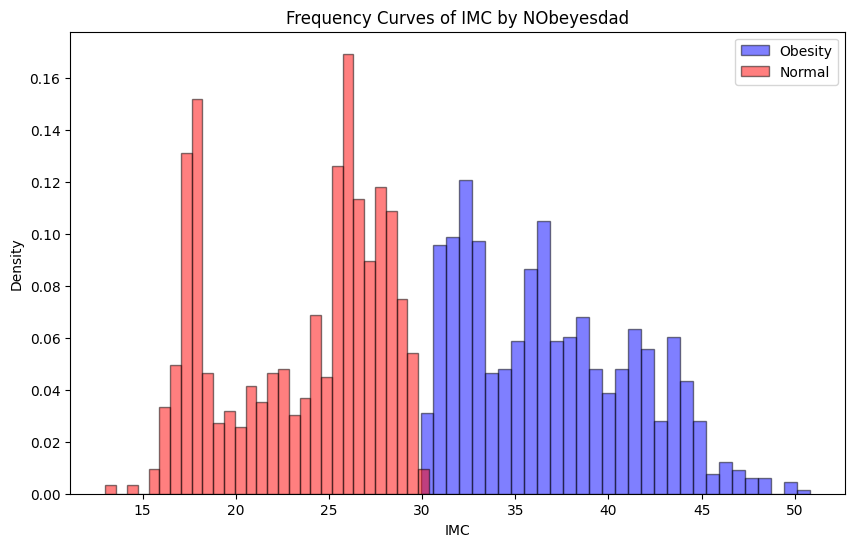

In [72]:
df[["Weight","Height","IMC", "NObeyesdad"]]

group1 = df[df['NObeyesdad'] == 'Obesity']
group2 = df[df['NObeyesdad'] == 'Normal Weight']

# Plot the frequency curves
plt.figure(figsize=(10, 6))

# Plot for the 'Obesity' group
plt.hist(group1['IMC'], bins=30, density=True, alpha=0.5, label='Obesity', color='blue', edgecolor='black')

# Plot for the 'Normal' group
plt.hist(group2['IMC'], bins=30, density=True, alpha=0.5, label='Normal', color='red', edgecolor='black')

# Add labels and title
plt.xlabel('IMC')
plt.ylabel('Density')
plt.title('Frequency Curves of IMC by NObeyesdad')
plt.legend()

# Show the plot
plt.show()

## **Pré-Processe os dados novamente**
**Dica 1:**
- Aproveite o que foi feito no trabalho anterior (remoção de outliers, transformação de valores e etc), lembrando que agora será necessario pré-processar as colunas novas criadas

**Dica 2:**
- Se estiver tendo problema com o OneHotEncoder criando valores NaN, resete o index do dataframe df original e do dataframe criado para o onehot para alinhar os dados

In [73]:
df['Height'] = df['Height'].fillna(df['Height'].mean())

age = df['Age']
Q1 = age.quantile(0.25)
Q3 = age.quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Age'] < (Q3 + 1.5*IQR)) & (df['Age'] > (Q1 - 1.5*IQR))]

height = df['Height']
Q1 = height.quantile(0.25)
Q3 = height.quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Height'] < (Q3 + 1.5*IQR)) & (df['Height'] > (Q1 - 1.5*IQR))]

weight = df['Weight']
Q1 = weight.quantile(0.25)
Q3 = weight.quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Weight'] < (Q3 + 1.5*IQR)) & (df['Weight'] > (Q1 - 1.5*IQR))]

frequency = ['no', 'Sometimes', 'Frequently', 'Always']
NObeyesdad = ['Normal Weight', 'Obesity']
oeCAEC = OrdinalEncoder(categories = [frequency])
oeCALC = OrdinalEncoder(categories = [frequency])
oeObe = OrdinalEncoder(categories = [NObeyesdad])
df['CAEC'] = oeCAEC.fit_transform(df[['CAEC']])
df['CALC'] = oeCALC.fit_transform(df[['CALC']])
df['NObeyesdad'] = oeObe.fit_transform(df[['NObeyesdad']])

leG = LabelEncoder()
df['Gender'] = leG.fit_transform(df['Gender'])
leFam = LabelEncoder()
df['family_history_with_overweight'] = leFam.fit_transform(df['family_history_with_overweight'])
leFav = LabelEncoder()
df['FAVC'] = leFav.fit_transform(df['FAVC'])
leSmo = LabelEncoder()
df['SMOKE'] = leSmo.fit_transform(df['SMOKE'])
leScc = LabelEncoder()
df['SCC'] = leScc.fit_transform(df['SCC'])

ohe = OneHotEncoder(sparse_output=False)
mtrans = ohe.fit_transform(df[['MTRANS']])
dfMTRANS = pd.DataFrame(mtrans, columns=ohe.get_feature_names_out(['MTRANS']))
df.drop(columns=['MTRANS'], axis = 1, inplace = True)
df.reset_index(drop=True, inplace=True)
dfMTRANS.reset_index(drop=True, inplace=True)
df = pd.concat([df, dfMTRANS], axis = 1)

df.drop(columns=['TW1'], axis=1, inplace=True)

df["IMC"] = df["Weight"] / (df["Height"] ** 2) # did it again here because height had null values, and we only removed them now, and we still need to normalize it

scaler = MinMaxScaler()
cols = df.select_dtypes(include='number').columns
df[cols] = scaler.fit_transform(df[cols])




## **Criação de Conjuntos de Treinamento e Teste**

Divida os dados em conjuntos de treino, validação e teste. Para isso, selecione aleatoriamente e sem reposição 75% dos registros para o conjunto de treinamento. As observações restantes (25%) serão ditribidas igualmente para os conjuntos de validação e teste.

Dicas:
- Fixe a semente de geração de dados aleatórios (escolha um número), utilize o comando `np.random.seed(escolha um número)`, antes de executar qualquer célula de comando que possa variar de valor resultante toda vez que for executada.

- Para fazer a divisão de treino, validação, teste use a função `train_test_split()`


In [74]:
np.random.seed(42)
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

## **Treine e Teste o Modelo de KNN**

Treinar cinco versões diferentes do modelo K-Nearest Neighbors (KNN) utilizando valores variados para o parâmetro K.

**Dica:**
- Busque pela função `KNeighborsClassifier(n_neighbors=?)` da biblioteca `scikitlearn`

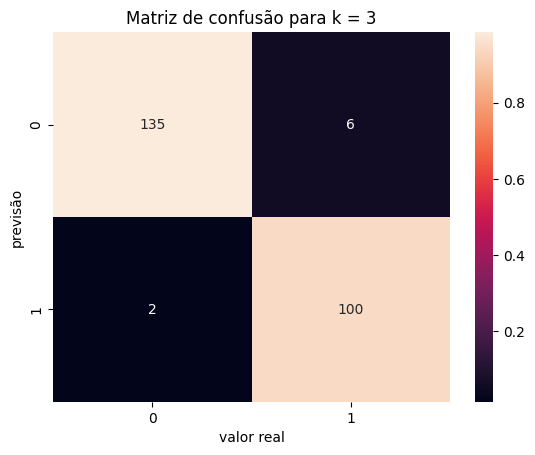

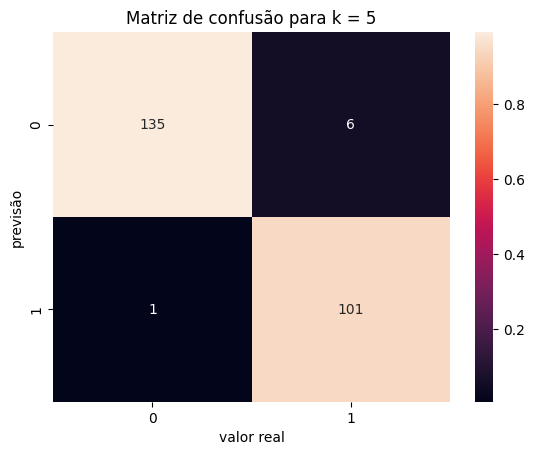

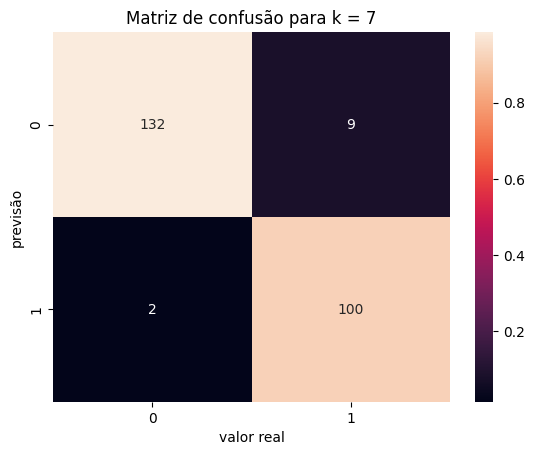

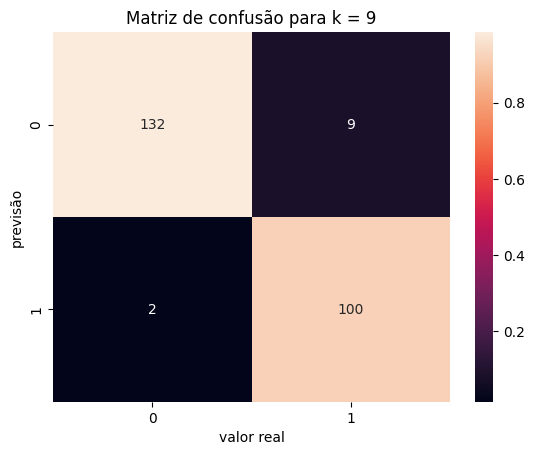

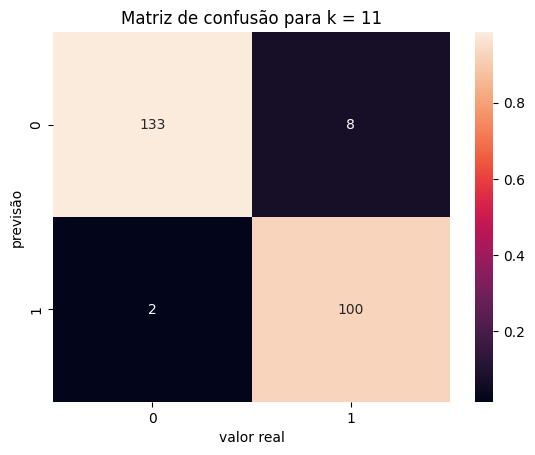

In [75]:
k_values = [3, 5, 7, 9, 11]
knn = []

for (i, k) in enumerate(k_values):
  knn.append(KNeighborsClassifier(n_neighbors=k))
  knn[i].fit(X_train, y_train)

  #building the confusion matrix
  
  y_pred = knn[i].predict(X_test)

  conf_matrix_color = confusion_matrix(y_test,y_pred, normalize='pred')
  conf_matrix = confusion_matrix(y_test,y_pred)
  sns.heatmap(conf_matrix_color, annot=conf_matrix, fmt="g")
  plt.title(f"Matriz de confusão para k = {k}")
  plt.ylabel("previsão")
  plt.xlabel("valor real")
  plt.show() #0 means that it predicted/is not obese and 1 means that it predicted/is obese


### **Interprete e explique a Matriz de Confusão gerada**

A matriz de confusão mostra de maneira bem clara onde e como cada modelo acertou sua previsão. Ela mostra bem a quantidade de pessoas no dataset que se encaixam em cada categoria, sendo elas Peso Normal, representado por 0 e Obesidade, representada por 1. Na diagonal principal você pode ver bem os casos onde o modelo acertou, e fora dela você vê como o modelo errou, neste caso o quadro superior direito mostra os casos onde o modelo achou que não era obeso mas era (falso negativo) e no quadro inferior esquerdo é onde o modelo achou que era obeso mas a pessoa não era (falso positivo).

Pela matriz de confusão percebemos que todos os valores de k estão bem próximos, mas o com melhores resultados é quando k = 5, que possui uma alta taxa de acerto, tendo uma diferença de apenas 1 acerto a mais se comparado com k = 3

### **Calcule e mostre as métricas de precisão, cobertura (recall) e medida F1 para cada classe, além da acurácia, todas para o conjunto de validação.**

**Dica:**
- Para calcular as métricas do modelo busque pelas funções `accuracy_score()`, `recall_score()`, `precision_score()`, `f1_score()`

In [76]:
cv_scores = {}
metrics = ["accuracy", "recall", "precision", "f1"]
for (i,k) in enumerate(k_values):
  #getting the cross-validation scores
  for metric in metrics:
    cv_scores[f"k{k}{metric}"] = cross_val_score(knn[i], X_train, y_train, cv=5, scoring=metric).mean()
  print(f"knn com k = {k}")
  print(f"Acurácia: {cv_scores[f'k{k}accuracy']:.4%}")
  print(f"Recall: {cv_scores[f'k{k}recall']:.4%}")
  print(f"Precisão: {cv_scores[f'k{k}precision']:.4%}")
  print(f"F1: {cv_scores[f'k{k}f1']:.4%}\n")

knn com k = 3
Acurácia: 94.8454%
Recall: 95.5325%
Precisão: 93.1821%
F1: 94.3180%

knn com k = 5
Acurácia: 94.3643%
Recall: 95.5337%
Precisão: 92.2251%
F1: 93.8203%

knn com k = 7
Acurácia: 93.8832%
Recall: 94.9159%
Precisão: 91.7509%
F1: 93.2819%

knn com k = 9
Acurácia: 94.0206%
Recall: 95.0698%
Precisão: 91.9248%
F1: 93.4366%

knn com k = 11
Acurácia: 93.0584%
Recall: 94.6094%
Precisão: 90.4482%
F1: 92.4307%



## **Baseado no desempenho em validação, escolher o melhor modelo utilizando uma das métricas (justificando a escolha da métrica)**

In [77]:
model = knn[0]

Foi escolhido o modelo com k = 3 pois, com exceção de recall, que é 0.0012% menor que o de k = 5, todas as suas métricas estão melhores que as de todos os outros modelos. 
Acredito que a métrica mais apropriada para se julgar melhores modelos ser o f1, pois é influenciado tanto pela precisão quanto pelo recall, e é melhor que a acurácia pois a acurácia tenta dar mais acertos totais, porém estamos mais preocupados com a avaliacão positiva neste contexto.

## **Avalie o modelo escolhido utilizando o dataset de teste**

In [ ]:
#model.predict(X_val, y_val)

## **Mostre uma análise comparativa entre validação e teste para o modelo escolhido**
**Observação:** Se houver uma discrepância muito grande nos resultados, algo pode estar errado, verifique seu treinamento e avaliação do modelo.